# Auto-bidding

Este notebook é uma introdução à pipeline introduzida para implementarmos e testarmos diferentes estratégias para resolver o problema de bidding. O código está estruturado em sessões, a primeira contendo uma visão geral da pipeline e as demais cobrem, com um nível maior de detalhe, alguns exemplos de como criar novos agentes e estratégias, testar estas estratégias, implementar novos algoritmos, gerar novos dados. O objetivo deste material é fornecer um guia abrangente, recomendo que seja usado como forma de consulta durante o desenvolvimento.


## Introdução

Este projeto está distribuído em 4 módulos que trabalham juntos para definir um agente de leilão e treiná-lo através de algoritmos diferentes de Reinforcement Learning.

```
bidding_train_env/  
│   import_utils.py
│   replaybuffer.py
│   utils.py
│
├── agents/
│   ├── actor/
│   │       base.py
│   │       mlp.py
│   │       transformer.py
│   │
│   ├── critic/
│   │       base.py
│   │       mlp.py
│   │
│   └── value/
│           base.py
│           mlp.py
│
├── algorithms/
│       base_algo.py
│       behavior_cloning.py
│       decision_transformer.py
│       iql.py
│       td3bc.py
│
├── envs/
│       base.py
│       offline_env.py
│
└── strategy/
        base_bidding_strategy.py
        simple_strategy.py
```

- **agents:** Inclui redes neurais comuns e aproximadores de função parametrizados utilizados em algoritmos de RL. Este módulo possui 3 submódulos: **actor**, que contém as redes neurais capazes de gerar ações a partir das observações, **critic**, que tentam estimar a recompensa esperada ao se tomar uma ação específica numa dada observação e **value**, que estimam a maior recompensa futura esperada dado uma certa observação.

- **strategy:** Abstração de alto nível para um agente de lances. Responsável pela lógica de representação de estado, sobre a qual o ator pode inferir, e pela decodificação de ações, que transforma a saída do ator nos valores de lance adequados.

- **envs:** Ambientes que simulam os processos de leilão e de resultados de impressão dos vencedores.

- **algorithms:** mplementações de algoritmos para treinar políticas de lances. As implementações são suficientemente gerais para aceitar diferentes estratégias e agentes com diferentes arquiteturas.

## Rodando algoritmos independentemente
A forma que recomendamos para uma exploração inicial, e também durante desenvolvimento é a de utilizar notebooks, assim como esse, no diretório root do projeto. Isso permite utilizar o framework como um pacote e realizar implementações novas sem que as demais sejam interferidas. Para isso, basta que importemos o `bidding_train_env` como um pacote junto com os demais.

In [1]:
import numpy as np
import pandas as pd
import torch

import random

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Caso a importação abaixo não funcione, pode ser que o pacote ainda não esteja instalado
# Para instalar, basta rodar o comando no diretório root do projeto:
# pip install -e .
import bidding_train_env as bidding

# Usa a GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Notebook reprodutível

def set_seed(seed):
    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

Para nos habituarmos com o ambiente e o problema, vamos escolher um ambiente inicial com uma estratégia simples. O módulo `envs` possui todos os ambientes disponíveis para simular o processo de leilão, em especial, o `OfflineBiddingEnv` é o ambiente usado para testar as estratégias e utiliza os dados coletados para simular o processo de leilão de forma mais fácil.

O ambiente simula um cenário em que vários agentes estão disputando as oportunidades, com isso, disponibilizamos um agente de leilão, representado por uma certa estratégia. Aqui, uma estratégia padrão é utilizada para fins de ilustração do funcionamento do ambiente, que possui dois métodos principais: `reset` e `step`. O método `reset` inicia o ambiente do zero, reiniciando o estado interno de todos os agentes e reiniciando as oportunidades, alguns métodos específicos, como `set_period` e `set_strategy`, que modificam estes estados internos do ambiente, funcionam melhor quando chamados imediatamente antes do `reset`.

In [2]:
base_strategy = bidding.strategy.BaseBiddingStrategy(
    budget   = 1000.,
    cpa      = 10.,
    category = 0
)

env = bidding.envs.OfflineBiddingEnv(
    strategy = base_strategy,
    period   = 7,
)

obs, info = env.reset()
obs

{'timeStepIndex': 0,
 'pValues': array([0.00596384, 0.00329353, 0.00059529, ..., 0.00048127, 0.00900464,
        0.00491926]),
 'pValueSigmas': array([4.53764257e-04, 8.81393150e-04, 8.89851125e-05, ...,
        8.39848486e-05, 1.08951911e-03, 5.24769116e-04]),
 'historyPValueInfo': [],
 'historyBid': [],
 'historyAuctionResult': [],
 'historyImpressionResult': [],
 'historyLeastWinningCost': []}

A saída do método é composto por um conjunto de informações que compõe o estado do ambiente de leilão até aquele momento e algumas informações úteis para avaliar o desempenho do agente até então. As informações que compõe uma observação são:

- **timeStepIndex**: Número do timestep atual de decisão. São 48 no total.
- **pValues**: Um array de valores, uma para cada oportunidade, referente à probabilidade esperada de conversão daquela oportunidade.
- **pValueSigmas**: Um array de valores, uma para cada oportunidade, indicando a incerteza dos valores de probabilidade anteriores.

Os 5 valores restantes são informações históricas de leilões anteriores e não aparecem após o `reset`. Todas as informações históricas são listas de arrays, uma para cada timestep de decisão:

- **historyPValueInfo:** Arrays contendo os _pValues_ e _pValueSigmas_ de leilões anteriores.
- **historyBid:** Arrays dos lances anteriores dados pelo agente.
- **historyAuctionResult:** Arrays dos resultados anteriores do leilão, cada linha é uma oportunidade, as duas primeiras colunas são valores booleanos indicando uma vitória ou não e a última coluna contendo o custo.
- **historyImpressionResult**: Arrays dos resultados de impressão do leilão. Ambas as colunas são booleanas e indicam se houve conversão da oportunidade.
- **historyLeastWinningCost:** Arrays dos custos de cada oportunidade, baseado no custo do terceiro lugar.

Após iniciar um ambiente através do `reset`, uma **ação** pode ser realizada, que está estruturada na forma de uma sequência de valores, que representam os valores dos lances dados para cada oportunidade. Uma estratégia é responsável por receber as informações de observação e gerar valores de lances através do método `bidding`. Uma vez com todos os valores de lances decididos, é possível realizar os lances no leilão através do método `step` do ambiente, que recebe a lista de lances e retorna 4 parâmetros: A nova observação do ambiente, a recompensa obtida após a impressão, um booleano indicando se o estado é terminal ou não e as informações de desempenho do agente até então.
<br>
<br>
<br>
<p align="center">
    <img src="resources/Bidding agent.svg" alt="Bidding agent" width="800"/>
</p>

In [3]:
bids = base_strategy.bidding(**obs)
bids

array([0.05963843, 0.03293534, 0.00595294, ..., 0.00481272, 0.09004644,
       0.04919264])

In [4]:
obs, reward, done, info = env.step(bids)
obs

{'timeStepIndex': 1,
 'pValues': array([0.00318085, 0.00273711, 0.00234695, ..., 0.00953994, 0.00592569,
        0.00850863]),
 'pValueSigmas': array([0.000401  , 0.00057405, 0.00039851, ..., 0.00010796, 0.00066971,
        0.00080535]),
 'historyPValueInfo': [array([[5.96384289e-03, 4.53764257e-04],
         [3.29353361e-03, 8.81393150e-04],
         [5.95294339e-04, 8.89851125e-05],
         ...,
         [4.81272053e-04, 8.39848486e-05],
         [9.00464440e-03, 1.08951911e-03],
         [4.91926385e-03, 5.24769116e-04]])],
 'historyBid': [array([0.05963843, 0.03293534, 0.00595294, ..., 0.00481272, 0.09004644,
         0.04919264])],
 'historyAuctionResult': [array([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]])],
 'historyImpressionResult': [array([[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]])],
 'historyLeastWinningCost': [

Deste modo, um agente de leilão deve processar um conjunto de informações que é acumulada a cada timestep e possui um número não constante de oportunidades a cada momento e deve retornar uma ação, que também não tem um número constante através dos timesteps. Esta característica dinâmica faz com que aproximadores de função tradicionais não sejam adequados como políticas parametrizadas, necessitando uma outra abordagem, com arquiteturas diferentes ou através da modelagem do problema com algumas suposições a mais. Quem é responśavel desta modelagem é a estratégia, que pode realizar codificação e decodificação da observação e da ação, respectivamente, para um espaço diferente, em que demais redes neurais podem ser utilizadas. Esta codificação, aqui chamada de pré-processamento da observação, e decodificação não são aprendidas, mas é o ator que é parametrizado e com quem o algoritmo de RL interage durante o treinamento.

<br>
<br>
<p align="center">
    <img src="resources/Agent-based strategy.svg" alt="Bidding agent" width="900"/>
</p>

Para exemplificar este caso, vamos pegar a estratégia mais simples, que codifica o estado através de um conjunto de 16 informações estatísticas sobre a observação do agente, representando um espaço estruturado, com diferentes tamanhos, num espaço compacto no $\mathbb{R}^{16}$. Como a representação do estado após o processamento possui tamanho fixo, uma rede neural comum poderia ser utilizada se a ação também possuir um tamanho fixo. Para que isso possa ser atingido, podemos adicionar a seguinte suposição sobre os valores de lances: O quanto queremos gastar é proporcional à probabilidade de conversão daquela oportunidade, ou seja, existe um $\alpha \in \mathbb{R}_{> 0}$ de forma que

$$\text{bids} = \alpha \cdot p_{\text{Values}}$$

Desta forma, codificamos os lances através de um único valor, $\alpha$, e queremos aprender um mapeamento $\pi: \mathbb{R}^{16} \to \mathbb{R}$, que recebe a observação pré-processada, que agora tem tamanho fixo, para uma ação codificada por um escalar, também de tamanho fixo, que representa o múltiplo que converte pValues em lances, condicionado ao estado atual. Este mapeamento pode ser aproximado por uma rede neural tradicional, por exemplo, que é o ator `DeterminisitcMLP`.

In [5]:
set_seed(42)

actor = bidding.agents.actor.DeterministicMLP(
    input_dim = 16,
    hidden_dims = [64, 64],
    output_dim = 1,
).to(device)

strategy = bidding.strategy.SimpleBiddingStrategy(
    actor = actor,
    budget = 1000.,
    cpa = 10.,
    category = 0,
)

Vamos ver a performance de um agente não-treinado:

In [6]:
actor.eval()

with torch.no_grad():
    obs, info = env.reset()

    cum_reward = 0
    done = False
    while not done:
        bid = strategy.bidding(**obs)

        obs, reward, done, info = env.step(bid)

        cum_reward += reward

info, cum_reward

({'conversions': 0, 'cpa': inf, 'wins': np.int64(0), 'score': 0},
 np.float64(0.0))

Nada boa, o mapeamento ainda não realiza ações que fazem sentido, vamos tentar alinhar a saída do modelo com os dados coletados através de um algoritmo de Offline Reinforcement Learning: Behavior cloning. Neste algoritmo, a ideia é que para casa observação, uma ação realizada no passado foi coletada e consideramos ela como realizada por um especialista. Desta forma, repetir o mesmo comportamento do especialista que coletou os dados, em teoria, pode retornar uma política que possui boa performance, tão boa quanto às ações coletadas. Desta forma, minimizamos a diferença entre a saída do ator e da ação do especialista, num estilo de aprendizado supervisionado:

$$\min_{\theta} \mathbb{E}_{s, \hat{a} \sim \mathcal{D}}\|\pi_\theta(s) - \hat{a}\|^2$$

Onde $\mathcal{D}$ é o Dataset de trajetórias coletadas por este especialista

In [7]:
dataset = pd.read_parquet('data/traffic/rl_data/rl_data.parquet')

print("Tamanho das observações pré-processadas: ", dataset['state'].shape)
print("Tamanho das ações codificadas:           ", dataset['action'].shape)

Tamanho das observações pré-processadas:  (48384, 16)
Tamanho das ações codificadas:            (48384,)


Para amostrar estas **experiências**, utilizamos um ReplayBuffer, um Dataloader para algoritmos de Reinforcement Learning, que guardam, além do estado e ação, a recompensa produzida, o próximo estado e também um indicador se o episódio terminou.

In [8]:
replay_buffer = bidding.ReplayBuffer.from_data(dataset, reward='continuous', device=device)

replay_buffer.sample(128)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([128]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next_state: Tensor(shape=torch.Size([128, 16]), device=cuda:0, dtype=torch.float32, is_shared=True),
        reward: Tensor(shape=torch.Size([128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        state: Tensor(shape=torch.Size([128, 16]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([128]),
    device=cuda,
    is_shared=True)

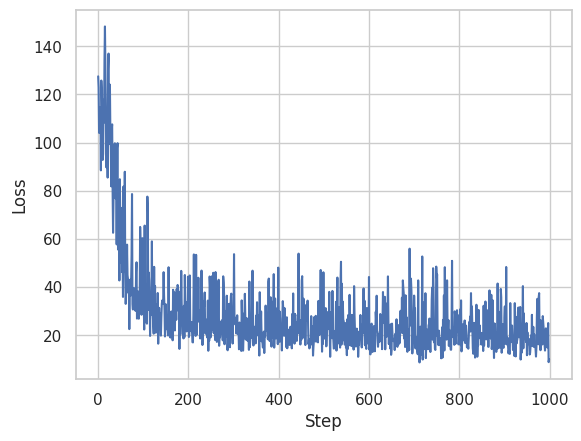

In [9]:
optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)

steps = 1000

losses = [0.] * steps

actor.train()
for i in range(steps):
    batch = replay_buffer.sample(128)

    action_pred = actor(batch['state']).view(batch['action'].shape)

    loss = (action_pred - batch['action']).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[i] = loss.item()

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [10]:
actor.eval()

with torch.no_grad():
    obs, info = env.reset()

    cum_reward = 0
    done = False
    while not done:
        bid = strategy.bidding(**obs)

        obs, reward, done, info = env.step(bid)

        cum_reward += reward

info, cum_reward

({'conversions': np.int64(109),
  'cpa': np.float64(9.173592249469225),
  'wins': np.int64(11773),
  'score': np.int64(109)},
 np.float64(218.0))

Bem melhor! Perceba que o algoritmo que utilizamos para treinar a agente não depende de nenhuma suposição que fazemos sobre o modelo, ou sobre a estratégia (caso os dados coletados já estejam processados de forma correta), deste forma, um algoritmo de RL pode ser montado de forma independente dos outros módulos aqui apresentados. Para garantir que isso ocorra, implementamos algoritmos que funcionam de forma genérica para diversos agentes e estratégias e podem ser chamados de forma fácil através do módulo de `algorithms`. Neste caso, uma forma equivalente de realizar o experimento acima seria utilizar o método `train_step`, presente nestes algoritmos, que recebe um batch de experiências e realiza um passo de treinamento, retornando um dicionário contendo informações úteis para acompanhar o treinamento do modelo.
<br>
<br>
<p align="center">
    <img src="resources/RL.svg" alt="Bidding agent" width="900"/>
</p>


Por exemplo, o algoritmo implementado acima poderia ser abstraído para uma class `BehaviorCloning`, movendo a lógica de treinamento para lá,

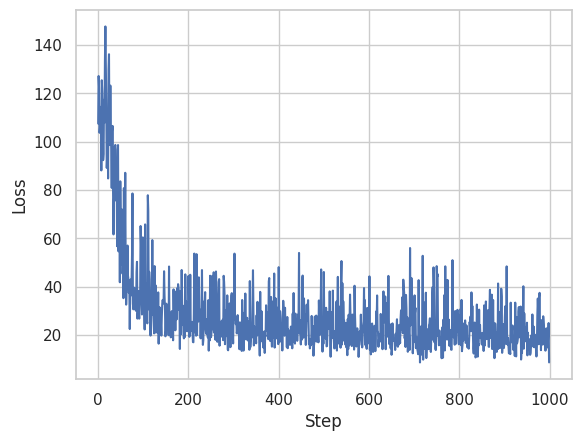

In [11]:
set_seed(42)

actor = bidding.agents.actor.DeterministicMLP(
    input_dim = 16,
    hidden_dims = [64, 64],
    output_dim = 1,
).to(device)

strategy = bidding.strategy.SimpleBiddingStrategy(
    actor = actor,
    budget = 1000.,
    cpa = 10.,
    category = 0,
)

optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)

bc = bidding.algorithms.BehaviorCloning(
    actor,
    optimizer
)

steps = 1000

losses = [0.] * steps

actor.train()
for i in range(1000):
    batch = replay_buffer.sample(128)

    loss = bc.train_step(batch)

    losses[i] = loss['loss/actor']

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [12]:
actor.eval()

with torch.no_grad():
    obs, info = env.reset()

    cum_reward = 0
    done = False
    while not done:
        bid = strategy.bidding(**obs)

        obs, reward, done, info = env.step(bid)

        cum_reward += reward

info, cum_reward

({'conversions': np.int64(105),
  'cpa': np.float64(9.522302057486456),
  'wins': np.int64(11904),
  'score': np.int64(105)},
 np.float64(210.0))

Outra possibilidade é utilizar as funcionalidade de treino embutidas nos algoritmos através dos métodos de `begin_experiment`, para iniciar um experimento no wandb e no tensorboard, e também `learn`, que realiza o treinamento automaticamente por você:

In [13]:
set_seed(42)

actor = bidding.agents.actor.DeterministicMLP(
    input_dim = 16,
    hidden_dims = [64, 64],
    output_dim = 1,
).to(device)

strategy = bidding.strategy.SimpleBiddingStrategy(
    actor = actor,
    budget = 1000.,
    cpa = 10.,
    category = 0,
)

optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)

bc = bidding.algorithms.BehaviorCloning(
    actor,
    optimizer
)

bc.learn(
    num_epochs      = 1,
    steps_per_epoch = 1000,
    replay_buffer   = replay_buffer,
    batch_size      = 128,
    env             = env,
    lr_scheduler    = None
)

[2024-09-18 12:43:37,847] [bidding_train_env.algorithms.base_algo] [base_algo.py(138)] [INFO] Calling learn before begin_experiment, no logging will be done and no weights will be saved.
Epoch 1/1: 100%|██████████| 1000/1000 [00:06<00:00, 146.32 steps/s, loss/actor=29] 


In [14]:
actor.eval()

with torch.no_grad():
    obs, info = env.reset()

    cum_reward = 0
    done = False
    while not done:
        bid = strategy.bidding(**obs)

        obs, reward, done, info = env.step(bid)

        cum_reward += reward

info, cum_reward

({'conversions': np.int64(105),
  'cpa': np.float64(9.522302057486456),
  'wins': np.int64(11904),
  'score': np.int64(105)},
 np.float64(210.0))

## Rodando experimentos através de arquivos de configuração

A pipeline para treinar e validar uma estratégia para um certo algoritmo de RL é bastante parecida entre algoritmos, mas alguns têm hiperparâmetros únicos, e às vezes redes neurais únicas também. Deste modo, para simplificar o processo de treinar e validar com diferentes hiperparâmetros, o diretório `/run` contém diversos scripts com exemplos para rodar experimentos e capacidade de rodar seus próprios experimentos com arquivos de configuração customizados.

Para rodar um algoritmo com a configuração padrão, como um exemplo, basta rodar o comando sem argumentos, ou seja:
```bash
python run/run_{algorithm name}.py
```

Se você tiver o [wandb](https://wandb.ai/home) funcionando em sua máquina, quaisquer resultados serão exportados, e as métricas do treinamento poderão ser acompanhadas no seu navegador. Se você quiser modificar a configuração atual para executar um algoritmo, vários arquivos de configuração .yaml podem ser encontrados em `/run ` e podem ser modificados. Para executar uma configuração personalizada, por favor, execute o seguinte comando
```bash
python run/run_{algorithm name}.py {path to config}.yaml
```


## Implementando novas estratégias

Para desenvolver novas estratégias, agentes, e algoritmos, alguns protocolos devem ser seguidos para garantir o funcionamento comum de todos os módulos. Esta sessão se preocupa em explicar os protocolos e fornecer uma documentação para o desenvolvimento de novas instâncias, de forma que a integração de uma nova implementação a biblioteca seja feita de forma correta e com poucos atritos.

Desta forma, utilize esta sessão como um material de consulta ao implementar uma nova classe, garantindo que todos os protocolos sejam atendidos.

### Implementando um novo agente

Agentes são redes neurais utilizadas como aproximadores de função no contexto de RL, cada rede possui uma certa função dependendo do algoritmo escolhido. Em geral, os tipos de aproximadores necessários normalmente caem em 3 tipos:
- **Atores:** Também chamados de políticas, mapeiam observações em ações, $\pi : \mathcal{S} \to \triangle(\mathcal{A})$
- **Críticos:** São redes que estimam o $Q$-valor, a recompensa acumulada esperada no futuro, de um par estado-ação, $Q: \mathcal{S} \times \mathcal{A} \to \mathbb{R}$
- **Valor:** São redes parecidas com críticos (às vezes são chamadas de críticos, ou baselines), que estimam o valor de um certo estado, a recompensa acumulada esperada, $V : \mathcal{S} \to \mathbb{R}$

---

#### Implementando um novo ator

Um agente precisa realizar um mapeamento de uma observação para uma ação, portanto, a rede deve receber um tensor que representa uma certa observação e deve retornar outro tensor que representa uma ação, de forma que a observação de entrada e a ação de saída sejam interpretadas por uma estratégia específica.

Para evitar que agentes sejam _hard-coded_ para estratégias específicas, uma escolha de implementação é deixar a inicialização do agente (`__init__`) mais genérica possível, permitindo que as dimensões de entrada e saída sejam modificadas conforme necessário, permitindo o uso de uma mesma rede para diversas estratégias ao mesmo tempo.

Políticas possuem divisão em relação ao modo que geram as ações, podendo ser **determinísticas** ou **estocásticas**. Políticas determinísticas retornam apenas um valor de ação para uma certa observação, enquanto estocásticas permitem que ações sejam amostradas de uma distribuição de probabilidade condicionada à observação. Um exemplo de política estocástica seria uma em que a ação é amostrada de uma distribuição Normal com média e desvio padrão que mudam conforme a observação encontrada. Ao implementar um ator estocástico, coloque o atributo de classe `stochastic` como verdadeiro.

```python
class NovoAgenteEstocástico(Agent):
    stochastic = True
```


O método `forward`, presente em quase todos os módulos de pytorch pode ser implementado e utilizado livremente conforme necessário, no entanto, para garantir o bom funcionamento do agente no ambiente, o método `get_action` deve ser corretamente implementado. Este método é o responsável pelo mapeamento efetivo da política, recebendo:
- obs: Um tensor de (batch_size, *observation_shape)
- action: Um tensor de (batch_size, *action_shape) ou None.
- deterministic: Um booleano indicando se a ação gerada deve ser determinística ou não..

A implementação do método `get_action` é livre desde que as entradas sigam este padrão e o método retorne 3 tensores:
- action: Um tensor de (batch_size, *action_shape)
- log_prob: Um tensor de (batch_size,) indicando o logaritmo da probabilidade daquelas ações terem sido amostradas (deve ser 0 quando a política é determinística)
- entropy: Um tensor de (batch_size), indicando a entropia da distribuição de origem da ação (deve ser 0 quando a política é determinística)

A presença do parâmetro de ação na entrada indica se a ação deve ser obtida ou não, no caso de atores determinísticos, este parâmetro é ignorado, já em atores estocásticos com deterministic=False, prover uma ação fixa a ação, retornando ela e a log_prob e entropy referentes à elas.
Abaixo, podemos ver um exemplo de um ator linear determinístico válido,

In [15]:
from torch import Tensor

class NovoAgente(bidding.agents.Actor):
    def __init__(
            self,
            input_dim: int,
            output_dim: int,
        ):
        super().__init__()

        # Implementação da rede do agente
        self.linear = torch.nn.Linear(input_dim, output_dim)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Aqui a implementação é livre
        return self.linear(x)
    
    def get_action(
            self,
            obs: Tensor,
            action: Tensor | None = None,
            deterministic: bool = False
        ) -> tuple[Tensor, Tensor, Tensor]:
        batch_size = obs.shape[0]

        return self(obs), torch.zeros(batch_size), torch.zeros(batch_size)

Atores ainda podem possuir métodos especiais, dependendo se eles possuem estados internos que devem ser armazenados ou não. Caso um ator precise armazenar estados intermediários, por exemplo, uma `LSTM` que guarda os vetores de contexto para realizar a inferência, então o método `reset` deve ser implementado para reiniciar este estado interno. Este método não recebe nenhum parâmetro e também não retorna nenhum parâmetro.

Caso a recompensa seja necessária para a inferência, por exemplo, para alterar o estado interno do ator, uma função de `callback` pode ser adicionada, recebendo a recompensa obtida e retornando valor algum. Por exemplo, um ator simples que coleta observações e recompensas poderia ser implementado da seguinte maneira,

```python
class AgentecomEstadoInterno(Actor):
    def reset(self):
        self.estado_interno = {'obs': [], 'reward': []}
    
    def callback(self, reward: float):
        self.estado_interno['reward'].append(reward)
```

---

#### Implementando Críticos e Redes de Valor

Redes de crítico e de valor, devido ao fato de sempre retornarem um valor real, são quaisquer redes neurais cuja saída sempre tem dimensão 1. Para garantir isso, novamente a implementação do `forward` é livre, mas métodos específicos devem ser implementados. Críticos devem implementar `get_q_value`, que recebe observações e ações e retorna um vetor uni-dimensional de reais representando os $Q$-valores, enquanto redes de valor devem implementar `get_value`, que recebe apenas observações
e retorna os valores de cada um, um vetor uni-dimensional real.

In [16]:
class NovoCrítico(bidding.agents.Critic):
    def __init__(
            self,
            obs_dim: int,
            act_dim: int,
        ):
        super().__init__()

        # Implementação da rede do agente
        self.linear = torch.nn.Linear(obs_dim + act_dim, 1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Aqui a implementação é livre
        return self.linear(x)
    
    def get_q_value(
            self,
            obs: Tensor,
            action: Tensor,
        ) -> Tensor:
        x = torch.cat([obs, action], dim=-1)

        # Deve retornar um tensor de dimensão (batch_size,)
        return self(x).view(-1)

---

### Implementando Novas Estratégias

Estratégias são agentes de leilão responsáveis por analisar o estado do ambiente e tomar a decisão dos lances, para cada oportunidade recebida. As estratégias podem ser aprendidas ou não e partir de diferentes suposições, todas controláveis através de métodos que analisam, codificam observações e decidem e decodificam ações para tornarem-se lances válidos. Para que uma nova estratégia seja criada, precisamos herdar as classes bases de estratégias: Caso sua implementação não utilize nenhuma rede neural para realizar a decisão, então herda-se a `BaseBiddingStrategy`, no caso em que um agente está por trás da decisão, deveremos herdar `BasePolicyStrategy`.

Os atributos bases disponíveis para serem utilizados são:
- _budget_ (float): Valor de dinheiro inicial do agente disponível para lances.
- _name_ (str): O Nome do agente.
- _cpa_ (float): Limite superior aceito pelo agente referente ao custo por conversão.
- _category_ (int): Categoria que o agente pertence.
- _remaining_budget_ (float): Quantia de dinheiro restante para ser gasta em lances.

Criar uma estratégia padrão, sem agentes, é uma tarefa mais simples: Basta escrever a lógica no método `bidding`, que recebe cada informação da observação de forma separada e retorna um array dos valores de lances que serão feitos, um para cada oportunidade recebida. Por exemplo, vamos criar um agente que olha para os pValues e dá um lance seguro considerando o desvio padrão:

$$\text{bids} = \text{cpa}_\text{limite} \cdot (p_\text{values} - \sigma_{\text{value}})$$

In [17]:
from numpy.typing import NDArray

class SecureStrategy(bidding.strategy.BaseBiddingStrategy):
    def __init__(
            self,
            budget: float = 100.,
            name: str     = "SecureStrategy",
            cpa: float    = 2.,
            category:int  = 1,
        ):
        super().__init__(budget, name, cpa, category)

    def bidding(
            self,
            timeStepIndex          : int,
            pValues                : NDArray,
            pValueSigmas           : NDArray,
            historyPValueInfo      : list[NDArray],
            historyBid             : list[NDArray],
            historyAuctionResult   : list[NDArray],
            historyImpressionResult: list[NDArray],
            historyLeastWinningCost: list[NDArray],
        ) -> NDArray:
        # Implementação da estratégia de lances
        return self.cpa * (pValues - pValueSigmas)

secure_strategy = SecureStrategy(
    budget   = 1000.,
    cpa      = 10.,
    category = 0
)

env = bidding.envs.OfflineBiddingEnv(
    strategy = secure_strategy,
    period   = 7,
)

with torch.no_grad():
    obs, info = env.reset()

    cum_reward = 0
    done = False
    while not done:
        bid = secure_strategy.bidding(**obs)

        obs, reward, done, info = env.step(bid)

        cum_reward += reward

info, cum_reward

({'conversions': np.int64(151),
  'cpa': np.float64(6.618968208209562),
  'wins': np.int64(13175),
  'score': np.int64(151)},
 np.float64(302.0))

Caso a estratégia seja baseada em agentes, ou seja, um ator é utilizado para gerar os lances, outras estruturas são necessárias para que a observação gerada pelo ambiente seja processada por uma rede neural. Assim como a saída da rede possa ser decodificada para gerar os lances individuais. A maior diferença em relação à estrutura anterior é um parâmetro adicional em sua inicialização: o referente ao ator responsável pela decisão.

Quando criamos uma estratégia customizada, modelamos o mapeamento das observações e ações considerando algumas suposições sobre o ambiente e como os lances são gerados. A lógica de codificação da observação é feita através de uma etapa de pré-processamento, que transforma de um dicionário, forma em que a observação original está estruturada, para uma representação interna. O método responsável por esta etapa é o `preprocess`, que recebe como entrada cada uma das informações originais do estado do ambiente e retorna um tensor contendo a representação daquela observação.

Caso o tensor de saída possua um número de dimensões fixos (o tamanho da dimensão pode variar), exporte esta dimensão através de um atributo de classe `observation_space`, através de uma sequência de `int`, ou `None`, caso aquela dimensão tenha tamanho igual ao número de oportunidades. Por exemplo, cada uma das representações abaixo teria os seguintes espaços:
- Vetor de características fixo com $n$ features: `observation_space=(n,)`
- Uma "imagem" de tamanho fixo: `observation_space=(n, m)`
- Sequência de características de cada oportunidades, com $n$ features cada: `observation_space=(None, n)`

Esta lógica de dimensões também se aplica às ações, saída do agente, que pode ser estruturada de diversas formas. O segundo método necessário é o `action_to_bid`, que contém a lógica capaz de decodificar esta ação de tamanho específico em lances, um valor para cada oportunidade. É importante que esse método não interrompa a passagem de gradiente, no caso de métodos que utilizam backpropagation sobre o valor dos lances.

Abaixo, vamos implementar uma nova estratégia, que codifica o estado num vetor de características, contendo as informações
- O pValue médio daquela rodada
- O desvio padrão dos pValues
- O pValueSigma médio daquela rodada
- A porcentagem de dinheiro restante
- O menor custo da rodada anterior

A saída esperada do ator é um valor único, que deve ser multiplicado pelos pValues para obter os lances.

In [21]:
class NovaEstratégia(bidding.strategy.BasePolicyStrategy):
    observation_shape = (4,)
    action_shape      = ()

    def __init__(
            self,
            actor: bidding.agents.Actor,
            budget: float = 100.,
            name: str     = "NovaEstratégia",
            cpa: float    = 2.,
            category:int  = 1,
        ):
        super().__init__(actor, budget, name, cpa, category)

    def preprocess(
            self,
            timeStepIndex          : int,
            pValues                : NDArray,
            pValueSigmas           : NDArray,
            historyPValueInfo      : list[NDArray],
            historyBid             : list[NDArray],
            historyAuctionResult   : list[NDArray],
            historyImpressionResult: list[NDArray],
            historyLeastWinningCost: list[NDArray],
        ) -> Tensor:
        # Implementação do pré-processamento
        return torch.Tensor(
            pValues.mean(),
            pValues.std(),
            pValueSigmas.mean(),
            self.remaining_budget / self.budget,
            historyLeastWinningCost[-1].mean(),
        )

    def action_to_bid(
            self,
            timeStepIndex          : int,
            pValues                : NDArray,
            pValueSigmas           : NDArray,
            historyPValueInfo      : list[NDArray],
            historyBid             : list[NDArray],
            historyAuctionResult   : list[NDArray],
            historyImpressionResult: list[NDArray],
            historyLeastWinningCost: list[NDArray],
            action: Tensor
        ) -> Tensor:
        # Implementação da estratégia de lances
        return action.view(()) * torch.from_numpy(pValues)

Coletar dados offline usando esta estratégia para treiná-la é um Work in Progress.